In [0]:
#Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
import numpy as np

import re
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


# Gensim
!pip install gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#lemmatization
import spacy

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
    100% |████████████████████████████████| 23.6MB 1.4MB/s 
    100% |████████████████████████████████| 1.4MB 13.5MB/s 
    100% |████████████████████████████████| 133kB 24.7MB/s 
    100% |████████████████████████████████| 61kB 18.5MB/s 
    100% |████████████████████████████████| 5.1MB 4.9MB/s 
    100% |████████████████████████████████| 552kB 20.1MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
    100% |████████████████████████████████| 1.6MB 12.0MB/s 
    100% |████████████████████████████████| 163kB 25.1MB/s 
  Running setup.py bdist_wheel for pyLDA

In [0]:
!python3 -m spacy download en

    100% |████████████████████████████████| 37.4MB 10.1MB/s 
  Running setup.py install for en-core-web-sm ... - \ | / done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [0]:
#List files inside the data folder in ML Team Drive (Google Drive)
!ls '/content/drive/Team Drives/Machine Learning/data'

data.csv      sample.csv		    yelp_checkin.csv
data_old.csv  yelp_business_attributes.csv  yelp_review.csv
ML_Test.csv   yelp_business.csv		    yelp_tip.csv
ML_Train.csv  yelp_business_hours.csv	    yelp_user.csv


In [0]:
#Read in data
business_att = pd.read_csv("/content/drive/Team Drives/Machine Learning/data/yelp_business_attributes.csv")
business = pd.read_csv("/content/drive/Team Drives/Machine Learning/data/yelp_business.csv") 
business_hours = pd.read_csv("/content/drive/Team Drives/Machine Learning/data/yelp_business_hours.csv")
check_in = pd.read_csv("/content/drive/Team Drives/Machine Learning/data/yelp_checkin.csv")
reviews = pd.read_csv("/content/drive/Team Drives/Machine Learning/data/yelp_review.csv")
tip = pd.read_csv("/content/drive/Team Drives/Machine Learning/data/yelp_tip.csv")
user = pd.read_csv("/content/drive/Team Drives/Machine Learning/data/yelp_user.csv")

In [0]:
#Merging Review table and Business Table (one review per record)
business_reviews = reviews.merge(business,how='inner',left_on = "business_id",right_on = "business_id")

In [0]:
print("There are a total of",business_reviews.shape[0],"Yelp reviews.") 

There are a total of 5261668 Yelp reviews.


In [0]:
#Other Restaurant Category Subsets
restaurant_reviews = business_reviews[business_reviews['categories'].str.contains("Restaurants")] #subset for only reviews of restaurants
bar_reviews = business_reviews[business_reviews['categories'].str.contains("Bars")] #subset for only reviews of Bars
brunch_reviews = business_reviews[business_reviews['categories'].str.contains("Brunch")] #subset for only reviews of Brunch
coffee_reviews = business_reviews[business_reviews['categories'].str.contains("Coffee")] #subset for only reviews of Coffee places

print("There are a total of",restaurant_reviews.shape[0],"Yelp reviews on restaurants.") 
print("There are",bar_reviews.shape[0],"Yelp reviews on bars.")
print("There are",brunch_reviews.shape[0],"Yelp reviews on Brunch restaurants.")
print("There are",coffee_reviews.shape[0],"Yelp reviews on Coffee shops.")

There are a total of 3221418 Yelp reviews on restaurants.
There are 1060651 Yelp reviews on bars.
There are 461429 Yelp reviews on Brunch restaurants.
There are 237500 Yelp reviews on Coffee shops.


In [0]:
##SUBSET 30000 REVIEWS FOR ML PROJECT

data = restaurant_reviews.sample(30000,random_state = 1234)

##Top 10 Ranked Cities by Review Count from 30K sample
data.city.value_counts().sort_values(ascending=False).iloc[0:10]

Las Vegas     8641
Phoenix       3008
Toronto       2827
Scottsdale    1675
Charlotte     1418
Pittsburgh    1169
Montréal       853
Tempe          850
Henderson      739
Chandler       661
Name: city, dtype: int64

In [0]:
##MERGE IN OTHER DATA TABLES

#Additional Cleaning 
#Get number of tips per Yelp business and number of tips per Yelp user

tip_business_count = tip.business_id.value_counts().rename_axis('business_id').reset_index(name='business_tip_count')
tip_user_count = tip.user_id.value_counts().rename_axis('user_id').reset_index(name='user_tip_count')

print("There are a total of",tip_business_count.shape[0],"businesses that received tips")
print("There are a total of",tip_user_count.shape[0],"users that gave tips")

There are a total of 112365 businesses that received tips
There are a total of 271679 users that gave tips


In [0]:
#Get total checkins per day per business
daily_checkin_counts = pd.DataFrame.pivot_table(check_in, values='checkins', index=['business_id'], columns=['weekday'], aggfunc=np.sum)
daily_checkin_counts = pd.DataFrame(daily_checkin_counts.to_records())
daily_checkin_counts = daily_checkin_counts.fillna(0) #Fill NaNs with 0

#Rename Daily Check In Counts columns
daily_checkin_counts.columns = ['business_id','fri_check_ins', 'mon_check_ins','sat_check_ins','sun_check_ins','thu_check_ins','tue_check_ins','wed_check_ins']

#Rename business_hours columns
business_hours.columns = ['business_id','mon_hours', 'tue_hours','wed_hours','thu_hours','fri_hours','sat_hours','sun_hours']

In [0]:
#Merge additional tables into 'data.csv' - Left Inner Join (to preserve the original dimensions from 'data.csv')

data = data.merge(business_att,how='left',left_on = "business_id",right_on = "business_id")
data = data.merge(business_hours,how='left',left_on = "business_id",right_on = "business_id")
data = data.merge(tip_business_count,how='left',left_on = "business_id",right_on = "business_id")
data = data.merge(daily_checkin_counts,how='left',left_on = "business_id",right_on = "business_id") #Can I assume 0 check ins for NaNs here?
data = data.merge(user,how='left',left_on = "user_id",right_on = "user_id")
data = data.merge(tip_user_count,how='left',left_on = "user_id",right_on = "user_id")

data.shape

(30000, 139)

In [0]:
## TOPIC MODELING

reviews = data['text'] #keep only reviews from 'data'

In [0]:
#Tokenization and Cleaning

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(reviews))

#Creating Bigram and Trigram Models

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
#Remove Stopwords, Make Bigrams and Lemmatize

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#def lemmatizing(text):
    #text = [wn.lemmatize(word) for word in tokenized_text]
    #return text
    
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
##Run the functions defined above

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

spacy.load('en')
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['thank', 'rosale', 'great', 'service', 'headache', 'tablet', 'people', 'ask', 'really', 'listen', 'answer', 'rosalie', 'hear', 'say', 'headache', 'offer', 'personal', 'stash', 'excedrin', 'extremely', 'grateful', 'extremely', 'nice', 'say', 'sincere', 'know', 'pay', 'deserve', 'top', 'dollar']]


In [0]:
#Create the Dictionary and Corpus needed for Topic Modeling

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]]


In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=num_topics, random_state=100, update_every=1, 
                                                chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

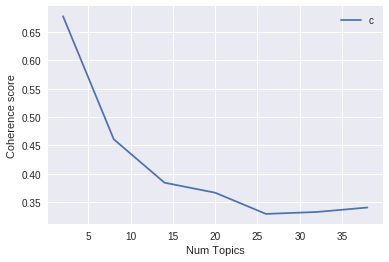

In [0]:
#Selecting Number of Topics

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
# Select the model and print the topics

##Although Model [0] with two topics had the highest corresponding score, two is not enough topics, so I am 
##selecting Model [1] with 8 topics as the optimal model.


optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.038*"order" + 0.022*"take" + 0.021*"say" + 0.020*"wait" + 0.018*"pizza" + '
  '0.017*"table" + 0.016*"get" + 0.015*"ask" + 0.013*"never" + 0.013*"server" '
  '+ 0.011*"even" + 0.010*"know" + 0.010*"minute" + 0.010*"time" + '
  '0.009*"tell" + 0.009*"come" + 0.009*"bad" + 0.009*"sit" + 0.008*"give" + '
  '0.008*"long" + 0.008*"leave" + 0.008*"want" + 0.007*"seat" + 0.007*"would" '
  '+ 0.007*"walk" + 0.007*"waitress" + 0.007*"bring" + 0.007*"see" + '
  '0.007*"drink" + 0.006*"could" + 0.006*"customer" + 0.006*"check" + '
  '0.006*"pay" + 0.006*"people" + 0.006*"go" + 0.006*"water" + '
  '0.006*"anything" + 0.005*"hour" + 0.005*"back" + 0.005*"do"'),
 (1,
  '0.047*"chicken" + 0.033*"sauce" + 0.032*"dish" + 0.026*"friend" + '
  '0.025*"salad" + 0.022*"rice" + 0.019*"order" + 0.017*"hot" + 0.016*"spicy" '
  '+ 0.015*"soup" + 0.013*"shrimp" + 0.013*"noodle" + 0.012*"flavor" + '
  '0.012*"beef" + 0.011*"sweet" + 0.010*"taste" + 0.010*"wing" + 0.009*"green" '
  '+ 0.009*"bowl" + 0.0

In [0]:
dat = data.text.values.tolist()

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=dat):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [0]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=dat)

#Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.3702,"good, food, place, go, get, come, service, try...",Thank you Rosale for the great service and a h...
1,1,3.0,0.3703,"good, food, place, go, get, come, service, try...",If you are in the Concord Mills area and have ...
2,2,3.0,0.4526,"good, food, place, go, get, come, service, try...",Hot dogs for breakfast??? HOT DOGS FOR BREAKFA...
3,3,0.0,0.5985,"order, take, say, wait, pizza, table, get, ask...",This Tropical Smoothies Cafe has the worst cus...
4,4,3.0,0.4442,"good, food, place, go, get, come, service, try...",I am stumped by the amazing food and service a...
5,5,3.0,0.4847,"good, food, place, go, get, come, service, try...",When it comes to affordable greek food in a co...
6,6,3.0,0.3686,"good, food, place, go, get, come, service, try...",This is a DEFINITE 4.5 stars!! Just popped in ...
7,7,3.0,0.2941,"good, food, place, go, get, come, service, try...",Love love loooooove the music oldies but goodi...
8,8,0.0,0.2849,"order, take, say, wait, pizza, table, get, ask...","Holy crap, this location is bad. Went in today..."
9,9,3.0,0.5161,"good, food, place, go, get, come, service, try...",Everything from the ambiance to the food is in...


In [0]:
#Count per Topic
df_dominant_topic.Dominant_Topic.value_counts()

3.0    26327
0.0     1971
7.0     1109
2.0      394
1.0      127
6.0       37
5.0       21
4.0       14
Name: Dominant_Topic, dtype: int64

In [0]:
topic_model = df_dominant_topic[['Dominant_Topic','Topic_Perc_Contrib','Keywords']] #df for topic column

#Putting it all together
data = pd.concat([data, topic_model], axis=1, join_axes=[data.index]) #append topic model fields into original data.csv

In [0]:
#Download data into local drive
#data.to_csv('data.csv')
#files.download('data.csv')

In [0]:
## More cleaning

#CLEANING

##Adding variables
data['useful_review'] = data['useful_x'].apply(lambda x: 1 if x > data['useful_x'].quantile(.90) else 0) #Turn useful_x review as a binary variable; Response
data['friends_count'] = data.friends.str.count(',').fillna(0) #total number of user's Yelp friends
data['totalwords'] = data['text'].str.split().str.len() #Add Total Words per Review
data['review_date'] = pd.to_datetime(data['date']) #convert review date to datetime type
data['yelping_since'] = pd.to_datetime(data['yelping_since']) #convert Yelping since date to datetime type
data['yelping_since_year'] = pd.DatetimeIndex(data['yelping_since']).year #add a Yelping Since Year column
data['review_year'] = pd.DatetimeIndex(data['review_date']).year #add a review year column
data['review_month'] = pd.DatetimeIndex(data['review_date']).month #add a review month column

#Clean up 'Elite' column. Create one column for each year that a user was an elite user
count_vect = CountVectorizer()
data['elite'] = data['elite'].str.replace(',',' ')
yelp_elite = count_vect.fit_transform(data['elite'])
yelp_elite.columns = count_vect.get_feature_names()
yelp_elite = pd.DataFrame(yelp_elite.toarray())
yelp_elite.columns = [s + "_elite" for s in count_vect.get_feature_names()]
yelp_elite = yelp_elite.fillna(0)

#Clean up 'Categories' column. Create one column for each category (1 or 0)
count_vect2 = CountVectorizer()
data['categories'] = data['categories'].str.replace(';',' ')
categories = count_vect2.fit_transform(data['categories'].values.astype('U'))
categories.columns = count_vect2.get_feature_names()
categories = pd.DataFrame(categories.toarray())
categories.columns = [s + "_category" for s in count_vect2.get_feature_names()] 
categories = categories.fillna(0)

#Keep only relevant categories
categories = categories[['acai_category','afghan_category','african_category','airports_category', 'american_category','animal_category','arabian_category','argentine_category',
'armenian_category','asian_category','australian_category','austrian_category','baby_category','bagels_category','bakeries_category','bangladeshi_category','bar_category',
'barbeque_category','bars_category','bartenders_category','bavarian_category','beer_category','belgian_category','beverage_category','bistros_category',
'boarding_category','brazilian_category','breakfast_category','breweries_category','brewpubs_category','brunch_category','buffets_category','buildings_category',
'burgers_category','burmese_category','butcher_category','cafe_category','cafes_category','cafeteria_category','cajun_category','cake_category','cakes_category',
'cambodian_category','canadian_category','candy_category','cantonese_category','champagne_category','cheese_category','cheesesteaks_category','chefs_category','chicken_category',
'chinese_category','chocolatiers_category','cideries_category','cocktail_category','coffee_category','coffeeshops_category','colombian_category','country_category',
 'cream_category','creole_category','creperies_category','croatian_category','cuban_category','cuisine_category','cultural_category','cupcakes_category',
 'curry_category','czech_category','delicatessen_category','delis_category','delivery_category','design_category','desserts_category','diners_category','dinner_category','distilleries_category',
 'dive_category', 'dominican_category','donuts_category','egyptian_category','empanadas_category','ethiopian_category','ethnic_category','european_category','farms_category',
 'filipino_category','fish_category','fondue_category','french_category','fruits_category','gastropubs_category','gay_category','gelato_category','german_category','gluten_category',
 'greek_category', 'guamanian_category','haitian_category','halal_category','hawaiian_category','herbs_category','himalayan_category','hobby_category',
 'honduran_category', 'horseback_category','hostels_category','hotel_category','hotels_category','hungarian_category', 'indian_category', 'indonesian_category', 'iranian_category',
 'irish_category', 'italian_category', 'izakaya_category', 'japanese_category', 'juice_category', 'karaoke_category', 'kebab_category', 'kong_category', 'korean_category',
 'laotian_category', 'latin_category', 'lebanese_category', 'malaysian_category', 'marinas_category', 'meat_category', 'mediterranean_category', 'mexican_category', 'mongolian_category', 'moroccan_category',
 'nepalese_category', 'nicaraguan_category', 'nightlife_category', 'noodles_category', 'olive_category', 'pakistani_category', 'pasta_category', 'patisserie_category',
 'persian_category', 'peruvian_category', 'pizza_category', 'poke_category', 'polish_category', 'portuguese_category', 'poutineries_category', 'pretzels_category', 'pub_category',
 'public_category', 'pubs_category', 'ramen_category', 'resorts_category', 'restaurants_category', 'roasteries_category', 'russian_category', 'salad_category', 'salvadoran_category', 'sandwiches_category', 'sausage_category',
 'scandinavian_category', 'scottish_category', 'seafood_category', 'security_category', 'serbo_category', 'shanghainese_category', 'singaporean_category', 'slovakian_category',
 'smokehouse_category', 'smoothies_category', 'soup_category', 'south_category', 'southern_category', 'spanish_category', 'speakeasies_category', 'specialty_category',
 'spices_category', 'spirits_category', 'sports_category', 'sri_category', 'stadiums_category', 'steakhouses_category', 'supper_category', 'sushi_category',
 'szechuan_category', 'tacos_category', 'taiwanese_category', 'tapas_category', 'tasting_category', 'tea_category', 'teppanyaki_category', 'thai_category',
 'themed_category', 'therapy_category', 'tiki_category', 'tobacco_category', 'traditional_category', 'travel_category', 'trucks_category', 'turkish_category',
 'tuscan_category', 'udon_category', 'ukrainian_category', 'vacation_category', 'vegan_category', 'vegetarian_category', 'veggies_category', 'venezuelan_category', 'vietnamese_category',
 'waffles_category','whiskey_category', 'wine_category','wineries_category', 'wings_category', 'women_category', 'yogurt_category']]

#Concatenate the new 'yelp_elite' and 'categories' dataframes that were just created to the dataset
frames = [data, yelp_elite, categories]
data = pd.concat(frames,axis=1, join_axes=[data.index])


##Working with NaN values

#Convert 'Na' string to NaN 
data = data.replace('Na', np.nan, regex=True) #Business Attribute have 'Na' as string type. Replace 'Na' as NaN.

#Convert the following columns that are datatype 'object' into datatype 'categorical' - May need to encode later for modeling
data['Dominant_Topic'] = data["Dominant_Topic"].astype('category') #convert Dominant_Topic from numerical to categorical
data['city'] = data.city.astype('category')
data['state'] = data.state.astype('category')
data['postal_code'] = data.postal_code.astype('category')

#Fill NaNs as 0
data['user_tip_count'] = data['user_tip_count'].fillna(0) #fill user_tip_count that are NaNs as 0
data['business_tip_count'] = data['user_tip_count'].fillna(0) #fill business_tip_count that are NaNs as 0
data['fri_check_ins'] = data['user_tip_count'].fillna(0) #Fill NaN check_ins as 0
data['mon_check_ins'] = data['user_tip_count'].fillna(0) #Fill NaN check_ins as 0
data['tue_check_ins'] = data['user_tip_count'].fillna(0) #Fill NaN check_ins as 0
data['wed_check_ins'] = data['user_tip_count'].fillna(0) #Fill NaN check_ins as 0
data['thu_check_ins'] = data['user_tip_count'].fillna(0) #Fill NaN check_ins as 0
data['sat_check_ins'] = data['user_tip_count'].fillna(0) #Fill NaN check_ins as 0
data['sun_check_ins'] = data['user_tip_count'].fillna(0) #Fill NaN check_ins as 0

#Dropping rows
data = data.dropna(subset=['postal_code']) #drop the five rows that don't have postal codes
data = data.dropna(subset=['categories']) #drop the single row with a missing category
data = data.dropna(subset=['city']) #drop the two rows that don't have postal codes

#Dropping columns
data = data.dropna(thresh= len(data) * .25, axis=1) #drop columns that have at least 30% missing values
data = data.drop(['user_id','review_id','business_id','date','text',
                  'address','elite','categories','name_x','name_y','useful_x',
                  'neighborhood','BusinessParking_street',
                  'BusinessParking_validated','BusinessParking_lot','BusinessParking_valet',
                  'HairSpecializesIn_coloring','BikeParking','friends','Topic_Perc_Contrib',
                  'longitude','latitude','Keywords'], axis=1) #dropping additional variables that had at least 25% missing

#data = data.fillna(0) 

#convert topic into categorical
#dropping id columns, dropping text column - already extracted features (numwords, topics, etc), address, etc